## Example of the affect of defining misspecified prior densities on branch lengths

Amine Remita

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from nnTreeVB.data import evolve_seqs_full_homogeneity    
from nnTreeVB.data import build_tree_from_nwk
from nnTreeVB.data import simulate_tree
from nnTreeVB.data import build_msa_categorical
from nnTreeVB.data import TreeSeqCollection
#
from nnTreeVB.checks import check_sim_blengths
from nnTreeVB.checks import check_sim_simplex
#
from nnTreeVB.reports import plot_weights_grads_epochs
from nnTreeVB.reports import violinplot_from_dataframe
#
from nnTreeVB.models.vb_models import VB_nnTree
from nnTreeVB.models.evo_models import compute_log_likelihood
#
from nnTreeVB.utils import compute_rates_from_kappa

In [3]:
import time
import math
import random
import copy
from pprint import pprint
from collections import OrderedDict

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=5)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', "r'All-NaN (slice|axis) encountered'")

In [5]:
verbose = True

device = torch.device("cpu")
# # device = torch.device("cuda")

In [7]:
# seed = 49685
seed = 43
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sequence alignment simulation

In [8]:
## Define a function to simulate complete dataset (sequence alignment + tree)
## Branch lengths will be sampled from an exponential distribution with a mean defined by the user

def simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001,
    rates_str="0.16",
    freqs_str="0.25",
    verbose=0):

    # Simulate branch lengts
    rate = 1 / blen_mean
    sim_blengths = check_sim_blengths("exponential({})".format(rate), nb_taxa)[0]
    
    if verbose:
        print("Simulated brench lengths:")
        print("Number: {}".format(len(sim_blengths)))
        print("Mean: {}".format(np.mean(sim_blengths)))
        print("Variance: {}".format(np.var(sim_blengths)))
        print("Tree length: {}".format(np.sum(sim_blengths)))

    # Simulate tree
    tree_data = simulate_tree(nb_taxa, sim_blengths, seed)

    the_tree = tree_data[0]
    taxa = list(tree_data[1].keys())

    str_tree = the_tree.write(format=1) # get newick string
    the_tree.write(format=1, outfile=tree_file)
    
    # Sequence evolutionary parameters simulation
    sim_rates = check_sim_simplex(rates_str, 6)[0]
    #
    sim_freqs = check_sim_simplex(freqs_str, 4)[0]
    sim_freqs[1], sim_freqs[2] = sim_freqs[2], sim_freqs[1] # order of nuc is different in pyvolve

    # Sequence simulation using pyvolve
    all_seqdict = evolve_seqs_full_homogeneity(
        str_tree,
        fasta_file=False,
        nb_sites=alignment_len,
        subst_rates=sim_rates,
        state_freqs=sim_freqs,
        return_anc=True,
        verbose=verbose)

    sequences = [all_seqdict[s] for s in taxa]
    seq_taxa = {s:all_seqdict[s] for s in taxa}
    
    # write fasta file
    records = [SeqRecord(Seq(seq_taxa[taxon]), taxon, '', '') for taxon in seq_taxa]
    SeqIO.write(records, fasta_file, "fasta")
    
    # Extract branch lengths from the tree
    true_branches = torch.zeros(len(the_tree.get_descendants()))
    # print(true_branches.shape[0])

    for node in the_tree.traverse("postorder"):
        if node.postrank < true_branches.shape[0]:
            true_branches[node.postrank] = node.dist

    true_branches = true_branches.unsqueeze(-1)

    if verbose:
        print("\ntrue_branches")
        print(len(true_branches))
        print(true_branches.sum())

    # Build a treeSeq collection
    treeseqs = TreeSeqCollection(fasta_file, tree_file)
    tree_obj = treeseqs.tree
    logl_tree = copy.deepcopy(tree_obj)
    
    # Compress the alignment to get the site patterns
    motifs_cats = build_msa_categorical(treeseqs, nuc_cat=False)
    x = torch.from_numpy(motifs_cats.data)
    x, x_counts = x.unique(dim=0, return_counts=True)

    return true_branches, tree_obj, x, x_counts

In [ ]:
## Test function
fasta_file = 'sim.fasta'
tree_file = 'sim.nw'

blens, obj_tree, X, X_counts = simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001, verbose=1)

## Fitting and sampling nnTreeVB models

In [9]:
def fit_sample_vb_model(
    # init and fit hyperparams
    tree_obj,
    x,
    x_counts,
    #
    subs_model="jc69",
    # branch lengths prior hyperparams
    b_prior_dist="exponential",
    b_prior_params=[10.],
    b_learn_prior=False,
    #
    # Rates prior hyperparams
    r_prior_dist="dirichlet",
    r_prior_params=[1.]*6,
    r_learn_prior=False,
    #
    # Freqs prior hyperparams
    f_prior_dist="dirichlet",
    f_prior_params=[1.]*4,
    f_learn_prior=False,
    #
    elbo_type="elbo",
    grad_samples=torch.Size([1]),
    alpha_kl=1.,
    max_iter=1000,
    optimizer="adam",
    learning_rate=0.1,
    weight_decay=0.0,
    scheduler_lambda=lambda epoch: 1.0,
    save_fit_history=False,
    save_grad_stats=False,
    save_weight_stats=False,
    verbose=2,

    # sampling hyperparams
    nb_samples = torch.Size([1000])):

    if verbose:
        print("\tInitialize the model")
    
    model = VB_nnTree(
        copy.deepcopy(tree_obj),
        subs_model=subs_model,
        
        ## Branch lengths
        # Prior hyperparams
        b_prior_dist=b_prior_dist,
        b_prior_params=b_prior_params,
        b_learn_prior=b_learn_prior,
        # Variational hyperparams
        b_var_dist="normal",
        b_var_params=[0.1, 0.1],
        b_var_transform=torch.distributions.ExpTransform(),
        
        ## GTR Rates
        # Prior hyperparams
        r_prior_dist=r_prior_dist,
        r_prior_params=r_prior_params,
        r_learn_prior=r_learn_prior,
        # Variational hyperparams
        r_var_dist="normal",
        r_var_params=[0.1, 0.1],
        r_var_transform=torch.distributions.StickBreakingTransform(),

        ## GTR Freqs
        # Prior hyperparams
        f_prior_dist=f_prior_dist,
        f_prior_params=f_prior_params,
        f_learn_prior=f_learn_prior,
        # Variational hyperparams
        f_var_dist="normal",
        f_var_params=[0.1, 0.1],
        f_var_transform=torch.distributions.StickBreakingTransform(),
        
        ##
        device="cpu"
    )
    
    if verbose:
        print("\tFit the model")

    model.fit(
        x, 
        x_counts,
        elbo_type=elbo_type,
        grad_samples=grad_samples,
        alpha_kl=alpha_kl,
        max_iter=max_iter,
        optimizer=optimizer,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        scheduler_lambda=scheduler_lambda,
        save_fit_history=save_fit_history,
        save_grad_stats=save_grad_stats,
        save_weight_stats=save_weight_stats,
        verbose=verbose
    )
    
    if verbose:
        print("\tSample from the model")
    
    samples = model.sample(
        x, 
        x_counts,
        elbo_type=elbo_type,
        alpha_kl=alpha_kl,
        nb_samples=nb_samples
    )
    
    return model, samples

In [ ]:
## Test function
model, samples = fit_sample_vb_model(obj_tree, X, X_counts)

In [ ]:
print(samples["logl"])
print(samples["b"].mean(0).sum())

## Comparison 1. Branch lengths estimation

In [ ]:
# model_colors = ["tomato", "turquoise", "lightseagreen"]
# model_colors = ["salmon", "royalblue", "blueviolet"]
# model_colors = ["teal", "magenta", "gold"]
# model_colors = ["tomato", "green", "purple"]
# model_colors = ["#322e2f", "#d9138a", "#12a4d9"]

In [10]:
# Hyperparams of prior densities

prior_hyperparams = [["exponential", 0.1, False, "FPD(0.1)", "#322e2f"],
                     ["exponential", 0.01, False, "FPD(0.01)", "#322e2f"],
                     ["exponential", 0.001, False, "FPD(0.001)", "#322e2f"],
                     ["exponential", "uniform", True, "LPD", "#d9138a"],
                     ["exponential_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

### 1. Simulate a dataset

In [11]:
exp_mean_blens = 0.001
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 64

In [12]:
# Generate a dataset
fasta_file = 'sim_blens_{}_l{}_t{}.fasta'.format(str_exp_mean, aln_size, taxa_size)
tree_file = 'sim_blens_{}_l{}_t{}.nw'.format(str_exp_mean, aln_size, taxa_size)

blens, obj_tree, X, X_counts = simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=aln_size,
    nb_taxa=taxa_size,
    blen_mean=exp_mean_blens)

### 2. Fit and sample VB models w/ different prior densities

In [13]:
# Fit and sample multiple VB models with different prior densities
blen_samples = []
for i in range(len(prior_hyperparams)):
    print("\nVB model {}".format(prior_hyperparams[i][3]))

    model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                         subs_model="jc69",
                                         b_prior_dist=prior_hyperparams[i][0],
                                         b_prior_params=prior_hyperparams[i][1],
                                         b_learn_prior=prior_hyperparams[i][2],
                                         verbose=1)
    
    blen_samples.append(samples["b"])


VB model FPD(0.1)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.01)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.001)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. Mean of branch lenghts comparison

In [14]:
blens_mean = np.array([s.mean(1) for s in blen_samples])
blens_mean.shape

(5, 1000)

In [15]:
blens_mean = np.vstack(blens_mean).T
blens_mean.shape

(1000, 5)

In [16]:
df_bl_mean = pd.DataFrame(data=blens_mean, columns=model_names)
df_bl_mean.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.002166,0.002124,0.002137,0.001306,0.001348
std,0.000168,0.000150,0.000156,0.000087,0.000095
min,0.001736,0.001743,0.001704,0.001081,0.001087
25%,0.002050,0.002025,0.002027,0.001243,0.001282
50%,0.002154,0.002119,0.002126,0.001301,0.001344
75%,0.002269,0.002217,0.002232,0.001359,0.001405
max,0.002986,0.002614,0.002751,0.001633,0.001658


In [17]:
true_blen_mean = blens.mean()
true_blen_mean
# blens.shape

tensor(0.0010)

In [18]:
true_blen_mean

tensor(0.0010)

In [19]:
true_tree_len = blens.sum()

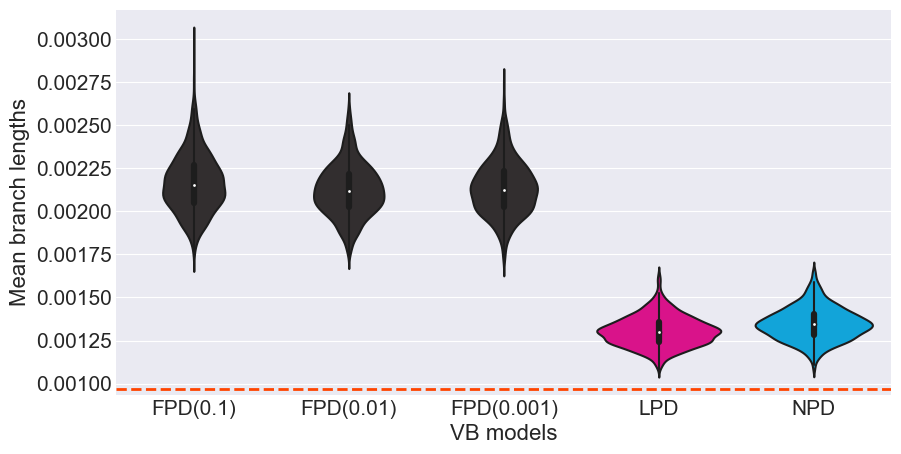

In [20]:
true_blen_mean = blens.mean().item() # horizontal line
violinplot_from_dataframe(df_bl_mean, 
                          line=true_blen_mean, 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Mean branch lengths",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

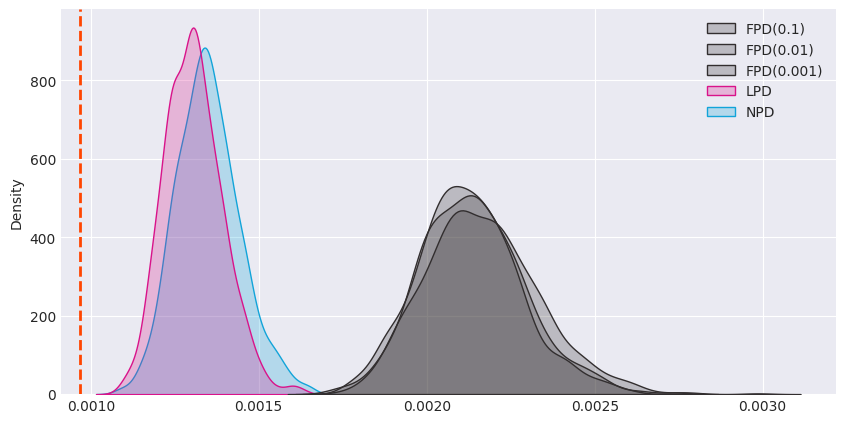

In [21]:
with plt.style.context('seaborn-darkgrid'):
    f, ax = plt.subplots(figsize=(10, 5))
    g = sns.kdeplot(ax=ax, data=df_bl_mean, palette=model_colors, fill=True)
    g.axvline(true_blen_mean, color="orangered", linestyle="--", linewidth=2)

### 4. Total tree length comparison

In [22]:
tree_lens = np.array([s.sum(1) for s in blen_samples])
tree_lens.shape

(5, 1000)

In [23]:
tree_lens = np.vstack(tree_lens).T
tree_lens.shape

(1000, 5)

In [24]:
df_tl = pd.DataFrame(data=tree_lens, columns=model_names)
df_tl.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.270693,0.265464,0.267126,0.163246,0.168503
std,0.021041,0.018742,0.019461,0.010881,0.011818
min,0.217005,0.217915,0.212965,0.135154,0.135872
25%,0.256302,0.253184,0.253355,0.155413,0.160254
50%,0.269278,0.264858,0.265798,0.162617,0.168058
75%,0.283634,0.277080,0.279060,0.169826,0.175595
max,0.373246,0.326706,0.343834,0.204183,0.207247


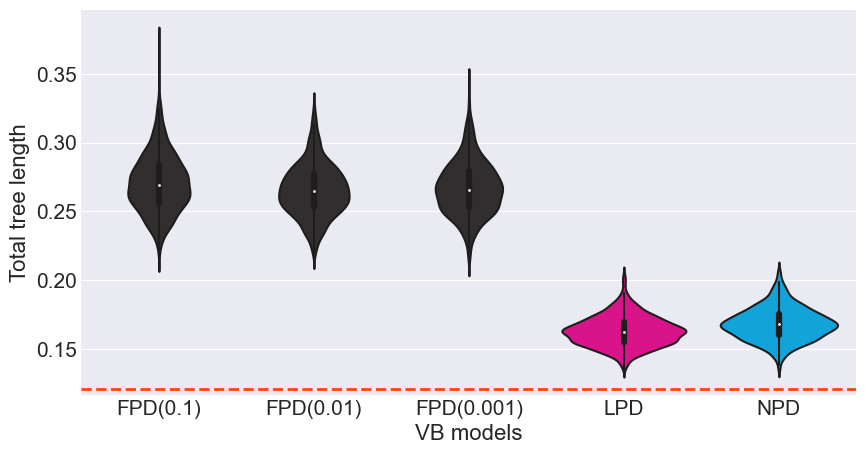

In [25]:
# import seaborn as sns
true_tree_len = blens.sum().item() # horizontal line
violinplot_from_dataframe(df_tl, 
                          line=true_tree_len, 
                          y_limit=[None, None],
                          xlabel="VB models", 
                          ylabel="Total tree length",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

## Comparison 2.  GTR rates estimation

In [26]:
# Model types
prior_hyperparams = [["dirichlet", [1.]*6 , False, "FPD(1)", "#322e2f"],
                     ["dirichlet", "uniform", True, "LPD", "#d9138a"],
                     ["dirichlet_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

# Dataset types
kappas = [0.25, 1, 4]

rates = [np.array(compute_rates_from_kappa(k)) for k in kappas]
rates_str = [",".join(map(str, compute_rates_from_kappa(k))) for k in kappas]

rates_names = ["AG", "AC", "AT", "GC", "GT", "CT"] # see nnTreeVB/reports.py

### 1. Simulate a dataset

In [27]:
exp_mean_blens = 0.1
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 64

In [28]:
# Generate datasets from different rates values
datasets = []

for k in range(len(kappas)):
    fasta_file = 'sim_blens_{}_l{}_t{}_k{}.fasta'.format(str_exp_mean, aln_size, taxa_size, kappas[k])
    tree_file = 'sim_blens_{}_l{}_t{}_k{}.nw'.format(str_exp_mean, aln_size, taxa_size, kappas[k])

    # blens, obj_tree, X, X_counts
    datasets.append(simulate_exp_blens_dataset(
        fasta_file,
        tree_file,
        alignment_len=aln_size,
        nb_taxa=taxa_size,
        blen_mean=exp_mean_blens,
        rates_str=rates_str[k]))

### 2. Fit and sample VB models w/ different prior densities

In [29]:
# Fit and sample VB models with different prior densities on different datasets
from collections import defaultdict

rates_samples = defaultdict(list)

for k_ind in range(len(kappas)):
    blens, obj_tree, X, X_counts = datasets[k_ind]

    for i in range(len(prior_hyperparams)):
        print("\nVB model {}".format(prior_hyperparams[i][3]))

        model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                             subs_model="gtr",
                                             r_prior_dist=prior_hyperparams[i][0],
                                             r_prior_params=prior_hyperparams[i][1],
                                             r_learn_prior=prior_hyperparams[i][2],
                                             verbose=1)

        rates_samples[k_ind].append(samples["r"])


VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. GTR rate samples

In [30]:
rates_samples[0][0].shape

(1000, 6)

In [81]:
k_ind = 2
dist_list = []
for i in range(len(prior_hyperparams)):
    scores = rates_samples[k_ind][i]
    
    dists = np.linalg.norm(rates[k_ind].reshape(1,-1) - scores, axis=-1)
    scaled_dists = 1-(1/(1+dists))

    dist_list.append(scaled_dists)

In [82]:
dist_list = np.array(dist_list)
dist_list.shape

(3, 1000)

In [83]:
dist_list = np.vstack(dist_list).T
dist_list.shape

(1000, 3)

In [84]:
df_rate_dists = pd.DataFrame(data=dist_list, columns=model_names)
df_rate_dists.describe()

,FPD(1),LPD,NPD
count,1000.000000,1000.000000,1000.000000
mean,0.012189,0.013239,0.010922
std,0.003611,0.003448,0.003293
min,0.002462,0.003643,0.002318
25%,0.009766,0.010834,0.008562
50%,0.011963,0.012972,0.010654
75%,0.014412,0.015350,0.012888
max,0.028370,0.025545,0.026123


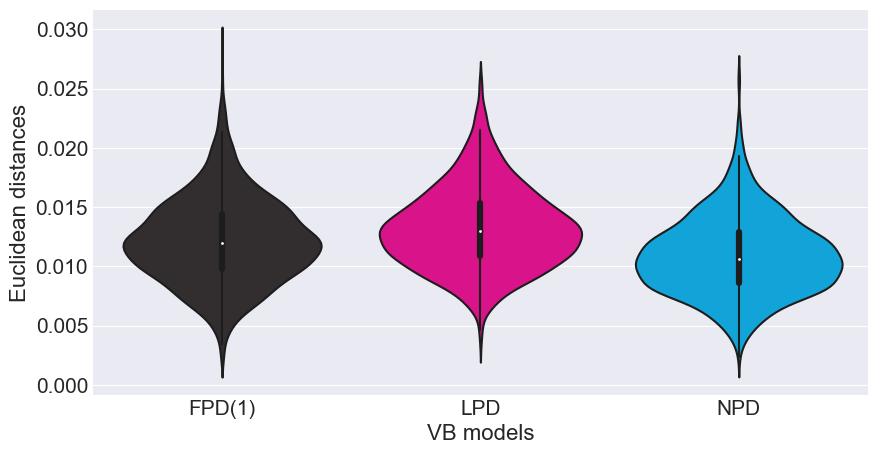

In [85]:
violinplot_from_dataframe(df_rate_dists, 
                          line="False", 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Euclidean distances",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

In [36]:
# Transform to a dataframe
df_rates = pd.DataFrame(columns=["Model", "K", "Rate", "Samples", "Real"])
sample_size = rates_samples[0][0].shape[0]

In [37]:
for k_ind in range(len(kappas)):
    for i in range(len(prior_hyperparams)):
        for r, rate in enumerate(rates_names):
            values = list()
            values.append([prior_hyperparams[i][3]]*sample_size) # Model
            values.append([kappas[k_ind]]*sample_size)           # K
            values.append([rate]*sample_size)                    # Rate
            values.append(rates_samples[k_ind][i][:,r])   # Sample values
            values.append([rates[k_ind][r]]*sample_size)    # Real value
            values = list(np.array(values, dtype="O").T)

            df_rates = pd.concat([df_rates, pd.DataFrame(values, columns=df_rates.columns)], ignore_index=True, copy=True)

In [38]:
df_rates.head()

,Model,K,Rate,Samples,Real
0,FPD(1),0.25,AG,0.054939,0.055556
1,FPD(1),0.25,AG,0.055306,0.055556
2,FPD(1),0.25,AG,0.057316,0.055556
3,FPD(1),0.25,AG,0.057905,0.055556
4,FPD(1),0.25,AG,0.055507,0.055556


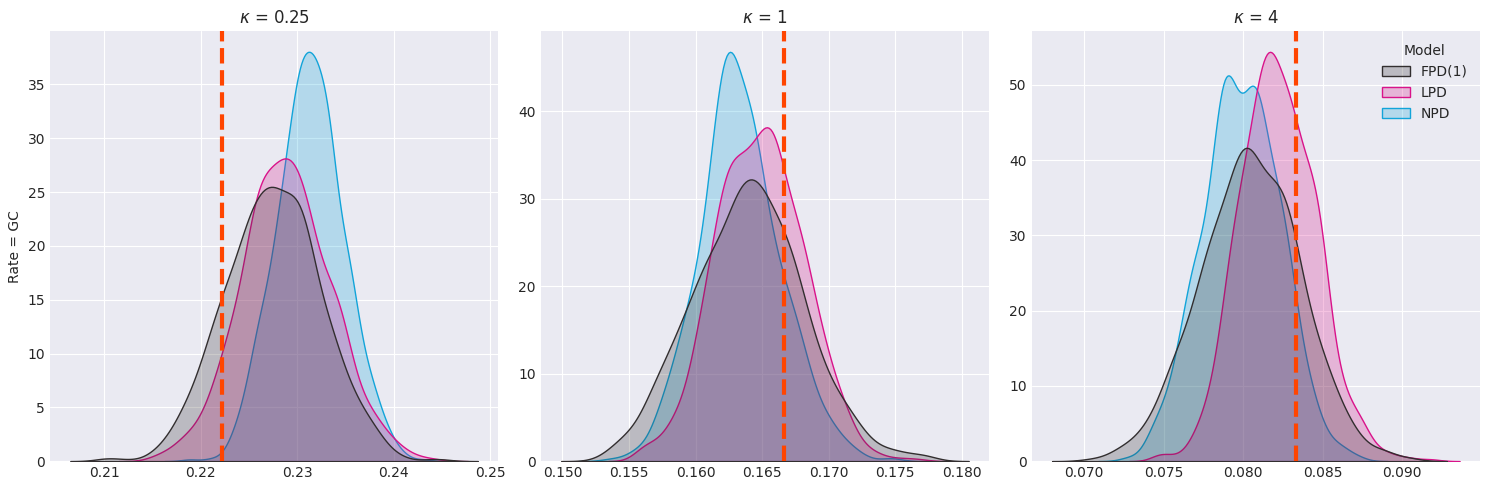

In [39]:
the_rate = "GC"

with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(1, 3, figsize=(15, 5))
    for k_ind, k in enumerate(kappas):
        legend = False
        if k_ind == len(kappas)-1: legend = True
        else: legend = False

        axe = axes[k_ind]
        data = df_rates[(df_rates["Rate"]==the_rate)&(df_rates["K"]==k)]

        g=sns.kdeplot(ax=axe, 
                      data=data, 
                      x="Samples",
                      hue="Model",
                      fill=True,
                      palette=model_colors,
                      legend=legend)

        x = data["Real"].unique().item()
        axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

        axe.set_title(r"$\kappa$ = {}".format(k))
        axe.set(xlabel=None)

        if k_ind !=0: 
            axe.set(ylabel=None)
        else:
            axe.set(ylabel=r"Rate = {}".format(the_rate))

    plt.tight_layout()

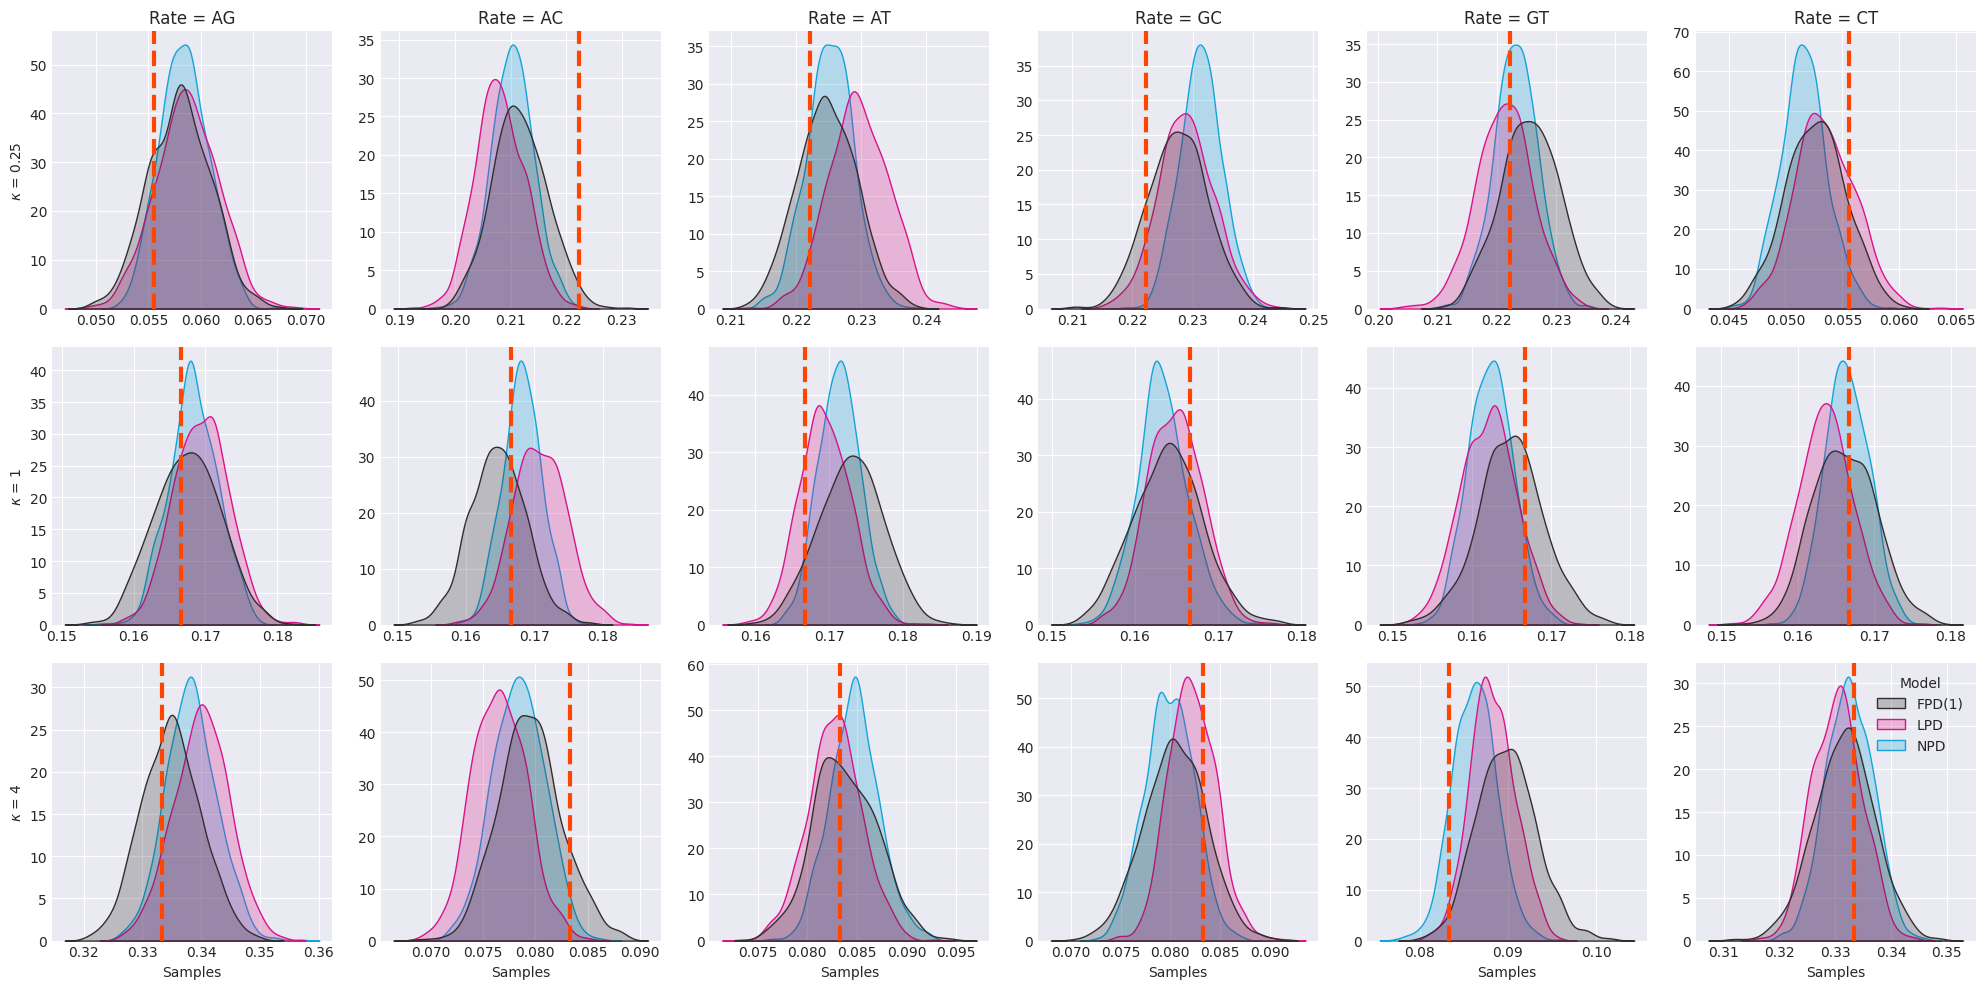

In [86]:
with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(len(kappas), len(rates_names), figsize=(20, 10))
#     plt.subplots_adjust(wspace=0.15, hspace=0.3)

    # Rows
    for k_ind, k in enumerate(kappas):
        # Columns
        for r_ind, r in enumerate(rates_names):
            legend = False
            if k_ind == len(kappas)-1 and r_ind == len(rates_names)-1: legend = True
            else: legend = False

            axe = axes[k_ind][r_ind]
            data = df_rates[(df_rates["K"]==k)&(df_rates["Rate"]==r)]

            g=sns.kdeplot(ax=axe, data=data, x="Samples", hue="Model", fill=True, palette=model_colors, legend=legend)

            x = data["Real"].unique().item()
            axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

            if k_ind == 0: axe.set_title(r"Rate = {}".format(rates_names[r_ind]))
            if k_ind != 2: axe.set(xlabel=None)
            if r_ind !=0: 
                axe.set(ylabel=None)
            else:
                axe.set(ylabel=r"$\kappa$ = {}".format(k))

plt.tight_layout() 

## Comparison 3.  GTR relative frequencies estimation

In [41]:
# Model types
prior_hyperparams = [["dirichlet", [1.]*4 , False, "FPD(1)", "#322e2f"],
                     ["dirichlet", "uniform", True, "LPD", "#d9138a"],
                     ["dirichlet_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

distr_freqs = ["dirichlet(10,1,1,10)",
               "dirichlet(10,10,10,10)",
               "dirichlet(1,10,10,1)"
              ]

distr_names = ["dir-10AT", "dir-10", "dir-10GC"]

# Each time, you run this cell, check_sim_simplex samples new values for freqs
freqs_str = [",".join(map(str, check_sim_simplex(distr, 4)[0])) for distr in distr_freqs]

freqs_list = np.array([list(map(float, f.split(","))) for f in freqs_str])

freqs_names = ["A", "G", "C", "T"]

### 1. Simulate a dataset

In [42]:
exp_mean_blens = 0.1
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 64

In [43]:
# Generate datasets from different rates values
datasets = []

for f_ind, freq_str in enumerate(freqs_str):
    distr_name = distr_names[f_ind]
    fasta_file = 'sim_blens_{}_l{}_t{}_f{}.fasta'.format(str_exp_mean, aln_size, taxa_size, distr_name)
    tree_file = 'sim_blens_{}_l{}_t{}_f{}.nw'.format(str_exp_mean, aln_size, taxa_size, distr_name)

    # blens, obj_tree, X, X_counts
    datasets.append(simulate_exp_blens_dataset(
        fasta_file,
        tree_file,
        alignment_len=aln_size,
        nb_taxa=taxa_size,
        blen_mean=exp_mean_blens,
        freqs_str=freq_str))

### 2. Fit and sample VB models w/ different prior densities

In [44]:
# Fit and sample VB models with different prior densities on different datasets
from collections import defaultdict

freqs_samples = defaultdict(list)

for fs_ind, freqs in enumerate(freqs_list):
    blens, obj_tree, X, X_counts = datasets[fs_ind]

    for i in range(len(prior_hyperparams)):
        print("\nVB model {}".format(prior_hyperparams[i][3]))

        model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                             subs_model="gtr",
                                             f_prior_dist=prior_hyperparams[i][0],
                                             f_prior_params=prior_hyperparams[i][1],
                                             f_learn_prior=prior_hyperparams[i][2],
                                             verbose=1)

        freqs_samples[fs_ind].append(samples["f"])


VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. GTR frequencies samples

In [45]:
freqs_samples[0][0].shape

(1000, 4)

In [71]:
f_ind = 2
f_dist_list = []
for i in range(len(prior_hyperparams)):
    scores = freqs_samples[f_ind][i]
    
    dists = np.linalg.norm(freqs[f_ind].reshape(1,-1) - scores, axis=-1)
    scaled_dists = 1-(1/(1+dists))

    f_dist_list.append(scaled_dists)

In [72]:
f_dist_list = np.array(f_dist_list)
f_dist_list.shape

(3, 1000)

In [73]:
f_dist_list = np.vstack(f_dist_list).T
f_dist_list.shape

(1000, 3)

In [74]:
df_freq_dists = pd.DataFrame(data=f_dist_list, columns=model_names)
df_freq_dists.describe()

,FPD(1),LPD,NPD
count,1000.000000,1000.000000,1000.000000
mean,0.394504,0.395069,0.394288
std,0.000663,0.000620,0.000567
min,0.392467,0.393006,0.392612
25%,0.394071,0.394644,0.393891
50%,0.394508,0.395075,0.394278
75%,0.394943,0.395510,0.394683
max,0.396657,0.397069,0.396155


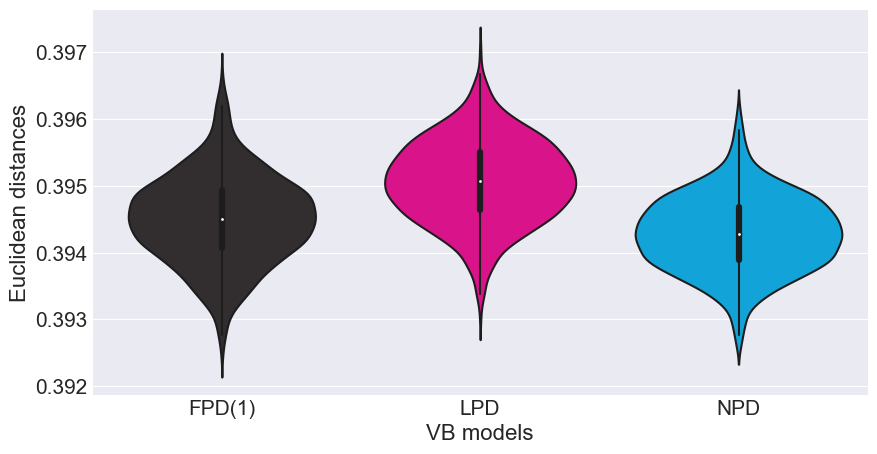

In [75]:
violinplot_from_dataframe(df_freq_dists, 
                          line="", 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Euclidean distances",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

In [51]:
# Transform to a dataframe
df_freqs = pd.DataFrame(columns=["Model", "Dir", "Freq", "Samples", "Real"])
sample_size = freqs_samples[0][0].shape[0]

In [52]:
for fs_ind, freqs in enumerate(freqs_list):
    distr_name = distr_names[fs_ind]

    for i in range(len(prior_hyperparams)):
        for f_ind, freq in enumerate(freqs_names):
            values = list()
            values.append([prior_hyperparams[i][3]]*sample_size) # Model
            values.append([distr_name]*sample_size)              # Dir
            values.append([freq]*sample_size)                    # Freq name
            values.append(freqs_samples[fs_ind][i][:,f_ind])     # Sample values
            values.append([freqs[f_ind]]*sample_size)    # Real value
            values = list(np.array(values, dtype="O").T)

            df_freqs = pd.concat([df_freqs, pd.DataFrame(values, columns=df_freqs.columns)], 
                                 ignore_index=True, 
                                 copy=True)

In [53]:
df_freqs.head()

,Model,Dir,Freq,Samples,Real
0,FPD(1),dir-10AT,A,0.481788,0.478961
1,FPD(1),dir-10AT,A,0.470480,0.478961
2,FPD(1),dir-10AT,A,0.468518,0.478961
3,FPD(1),dir-10AT,A,0.481066,0.478961
4,FPD(1),dir-10AT,A,0.467096,0.478961


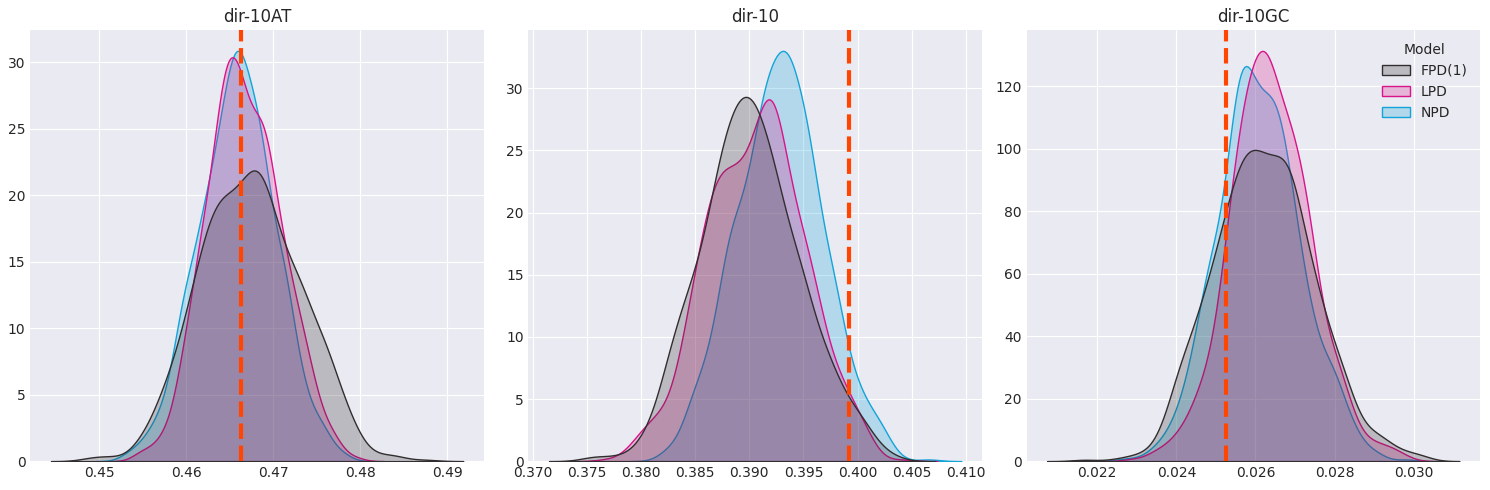

In [54]:
the_freq = "T"

with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(1, 3, figsize=(15, 5))
    for fs_ind, freqs in enumerate(freqs_list):
        distr_name = distr_names[fs_ind]

        legend = False
        if fs_ind == len(freqs_str)-1: legend = True
        else: legend = False

        axe = axes[fs_ind]
        data = df_freqs[(df_freqs["Freq"]==the_freq)&(df_freqs["Dir"]==distr_name)]

        g=sns.kdeplot(ax=axe, 
                      data=data, 
                      x="Samples",
                      hue="Model",
                      fill=True,
                      palette=model_colors,
                      legend=legend)

        x = data["Real"].unique().item()
        axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

        axe.set_title(r"{}".format(distr_name))
        axe.set(xlabel=None)

        if k_ind !=0: 
            axe.set(ylabel=None)
        else:
            axe.set(ylabel=r"{}".format(the_freq))

    plt.tight_layout()

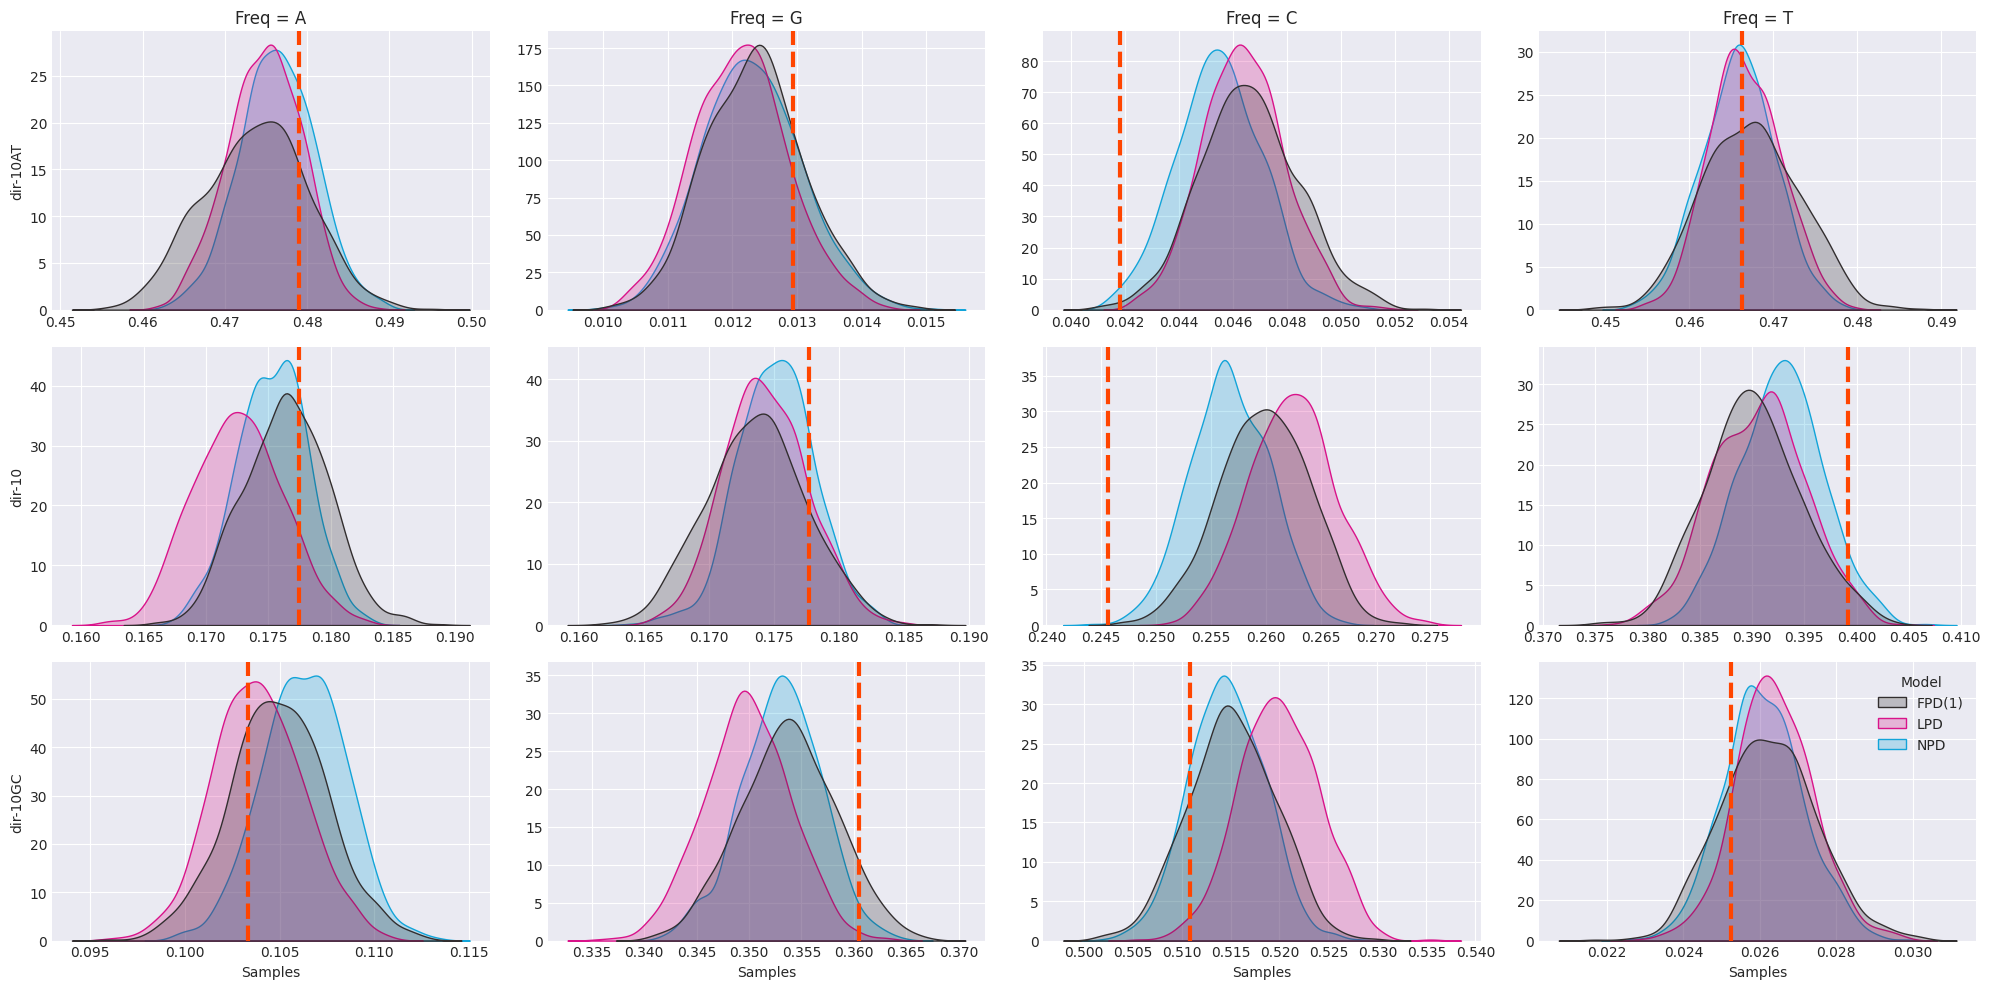

In [55]:
with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(len(freqs_list), len(freqs_names), figsize=(20, 10))
#     plt.subplots_adjust(wspace=0.15, hspace=0.3)

    # Rows
    for fs_ind, freqs in enumerate(freqs_list):
        distr_name = distr_names[fs_ind]
        # Columns
        for f_ind, freq_name in enumerate(freqs_names):
            legend = False
            if fs_ind == len(freqs_list)-1 and f_ind == len(freqs_names)-1: legend = True
            else: legend = False

            axe = axes[fs_ind][f_ind]
            data = df_freqs[(df_freqs["Dir"]==distr_name)&(df_freqs["Freq"]==freq_name)]

            g=sns.kdeplot(ax=axe, data=data, x="Samples", hue="Model",
                          fill=True, palette=model_colors, legend=legend)

            x = data["Real"].unique().item()
            axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

            if fs_ind == 0: axe.set_title(r"Freq = {}".format(freq_name))
            if fs_ind != 2: axe.set(xlabel=None)
            if f_ind !=0: 
                axe.set(ylabel=None)
            else:
                axe.set(ylabel=r"{}".format(distr_name))

plt.tight_layout()